In [1]:
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import cv2

# DATOS

In [2]:
def ShowPixels(pixels, shape=(112,92)):
    plt.imshow(pixels.reshape(shape))
    plt.show()

Img shape: (112, 92)
Done! X:(200, 10304) Y:(200,)
Img shape: (112, 92)
Done! X:(200, 10304) Y:(200,)
(200, 10304)
[48. 49. 45. ... 47. 46. 46.]


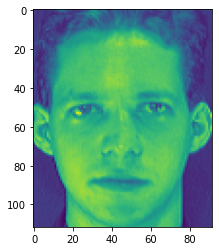

In [3]:
def GetSamplesMatrix(path):
  X = np.empty((0,10304))
  Y = np.array([])
  users = os.listdir(path)
  for i, user in enumerate(users):
      pics = os.listdir(path + '/' + user)
      for j, pic in enumerate(pics):
          img = cv2.imread(path + '/' + user + '/' + pic, 0).astype('float64') # 0 para leer grayscale
          img = img.flatten()
          #img /= 255
          X = np.append(X, [img], axis=0)
          Y = np.append(Y, user)
      print(f'{int(i/len(users)*100)}%', end='\r') 
  print(f"Img shape: {cv2.imread(path + '/' + user + '/' + pic, 0).shape}")
  print(f'Done! X:{X.shape} Y:{Y.shape}')

  return X, Y

train_path = './Train/'
X_train,Y_train = GetSamplesMatrix(train_path)

test_path = './Test/'
X_test,Y_test = GetSamplesMatrix(test_path)

print(X_train.shape)
print(X_train[0])
ShowPixels(X_train[0].reshape((112, 92, 1)))

# PCA

## Implementación

In [4]:
def GetB_PCA(X):

  X = X.T
  d = X.shape[0]
  n = X.shape[1]

  avg = np.average(X, axis=1).reshape((10304,1))
  A = X - avg
  Cprime = (1/d) * (np.dot(A.T, A))

  eigenvalues, Bprime = np.linalg.eig(Cprime)
  B = np.dot(A, Bprime)
  Bnorms = np.linalg.norm(B, axis=0)
  B = B / Bnorms

  return B

In [5]:
def Apply_PCA(X, B, k):
    mean = X.mean(axis=0).reshape((1,10304))
    A = X-mean
    return np.dot(A, B[:,:k])

In [6]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.decomposition import PCA

def AccuracyForEachK_PCA(B, K, knn, use_sklearn=False):
  acc = []

  for k in K:

    if use_sklearn:
      pca = PCA(n_components=k)
      Xpca_train = pca.fit_transform(X_train)
      Xpca_test = pca.transform(X_test)
    else:
      Xpca_train = Apply_PCA(X_train, B, k)
      Xpca_test = Apply_PCA(X_test, B, k)

    knn.fit(Xpca_train, Y_train)
    Y_pred = knn.predict(Xpca_test)
    acc.append(metrics.accuracy_score(Y_test, Y_pred))

  return acc

In [7]:
def AccuracyForEachNN_PCA(B, K, NN, use_sklearn=False):
  acc = np.array([])
  for i, nn in enumerate(NN):
    knn = KNeighborsClassifier(n_neighbors=nn)
    acc_nn = AccuracyForEachK_PCA(B, K, knn, use_sklearn)
    acc = np.append(acc, acc_nn, axis=0)
    print(f'{int(i/len(NN)*100)}%', end='\r') 
  acc = acc.reshape((len(NN),len(K)))
  return acc

## RESULTADOS

(10304, 200)


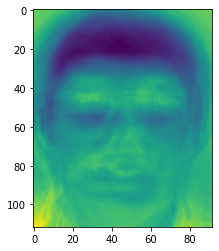

In [8]:
B_pca = GetB_PCA(X_train)
print(B_pca.shape)

eigenface = B_pca[:,0]
ShowPixels(eigenface)

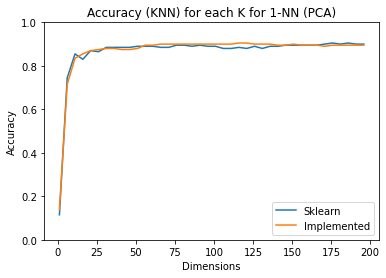

In [9]:
K = range(1,200,5)
knn = KNeighborsClassifier(n_neighbors=1)

implemented_acc = AccuracyForEachK_PCA(B_pca, K, knn, use_sklearn=False)
sklearn_acc = AccuracyForEachK_PCA(B_pca, K, knn, use_sklearn=True)

plt.title("Accuracy (KNN) for each K for 1-NN (PCA)")
plt.xlabel("Dimensions")
plt.ylabel('Accuracy')
plt.plot(K, sklearn_acc, label ='Sklearn')
plt.plot(K, implemented_acc, label ='Implemented')
plt.ylim([0.0, 1.0])
plt.legend()
plt.show()

In [10]:
acc = sklearn_acc
max_acc = max(acc)
max_index = acc.index(max_acc)
best_k = K[max_index]
print(f"Mejor precisión obtenida con sklearn: {max_acc} ({best_k} dimensiones)")

acc = implemented_acc
max_acc = max(acc)
max_index = acc.index(max_acc)
best_k = K[max_index]
print(f"Mejor precisión obtenida con implementación propia: {max_acc} ({best_k} dimensiones)")

Mejor precisión obtenida con sklearn: 0.905 (176 dimensiones)
Mejor precisión obtenida con implementación propia: 0.905 (116 dimensiones)


(5, 40)


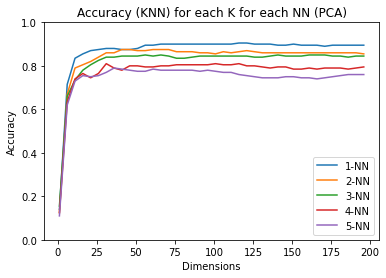

In [11]:
NN = range(1,6,1)
acc_NN = AccuracyForEachNN_PCA(B_pca, K, NN, use_sklearn=False)
print(acc_NN.shape)
plt.title("Accuracy (KNN) for each K for each NN (PCA)")
plt.xlabel("Dimensions")
plt.ylabel('Accuracy')
for i, nn in enumerate(NN):
  plt.plot(K, acc_NN[i], label =f'{nn}-NN')
plt.ylim([0.0, 1.0])
plt.legend()
plt.show()

# LDA

## Implementación

In [12]:
def GetB_LDA(X,Y):

    X = X.T
    avg = X.mean(axis=1)
    Sb = np.zeros((X.shape[0],X.shape[0]))
    Sw = np.zeros((X.shape[0],X.shape[0]))

    for c in set(Y):
        indices = np.where(Y == c)[0]
        Xc = X[:,indices]
        avgc = Xc.mean(axis = 1).reshape((X.shape[0],1))
        nc = Xc.shape[1]
        Sb += nc * (avgc - avg) * (avgc - avg).T
        Sw += np.dot((Xc - avgc), (Xc - avgc).T)
 
    C = np.linalg.inv(Sw) * Sb
    eigenvalues, B = np.linalg.eig(C)

    indices = np.argsort(eigenvalues)
    indices = np.flip(indices) # max to min
    B = B[indices]

    return B

In [13]:
def Apply_LDA(X,B,k):
    #avg = X.mean(axis=0)
    return np.dot(X, B[:,:k])

In [14]:
def AccuracyForEachK_LDA(B, K, knn):
  acc = []
  for k in K:
      Xlda_train = Apply_LDA(Xpca_train,B,k)
      Xlda_test = Apply_LDA(Xpca_test,B,k)
      knn = KNeighborsClassifier(n_neighbors=1)
      knn.fit(Xlda_train,Y_train)
      acc.append(knn.score(Xlda_test,Y_test))
  return acc

In [15]:
def AccuracyForEachNN_LDA(B, K, NN):
  acc = np.array([])
  for i, nn in enumerate(NN):
    knn = KNeighborsClassifier(n_neighbors=nn)
    acc_nn = AccuracyForEachK_LDA(B, K, knn)
    acc = np.append(acc, acc_nn, axis=0)
    print(f'{int(i/len(NN)*100)}%', end='\r') 
  acc = acc.reshape((len(NN),len(K)))
  return acc

## Resultados

In [16]:
Xpca_train = Apply_PCA(X_train, B_pca, best_k)
Xpca_test = Apply_PCA(X_test, B_pca, best_k)

In [17]:
B_lda = GetB_LDA(Xpca_train,Y_train)
print(B_lda.shape)

(116, 116)


In [18]:
K = range(1,best_k)
lda_acc = AccuracyForEachK_LDA(B_lda, K, knn)

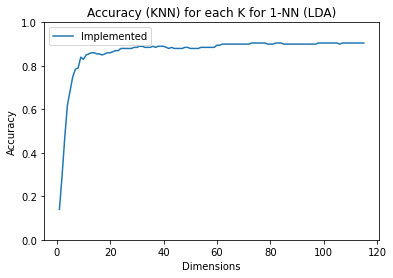

In [19]:
plt.title("Accuracy (KNN) for each K for 1-NN (LDA)")
plt.xlabel("Dimensions")
plt.ylabel('Accuracy')
plt.plot(K, lda_acc, label ='Implemented')
plt.ylim([0.0, 1.0])
plt.legend()
plt.show()

In [20]:
acc = lda_acc
max_acc = max(acc)
max_index = acc.index(max_acc)
best_k = K[max_index]
print(f"Mejor precisión obtenida con LDA: {max_acc} ({best_k} dimensiones)")

Mejor precisión obtenida con LDA: 0.905 (73 dimensiones)


(5, 115)


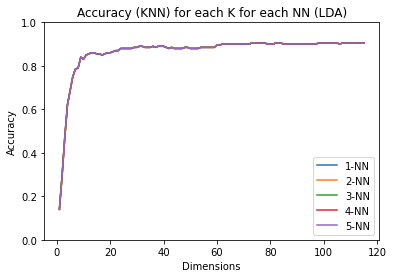

In [21]:
NN = range(1,6,1)
acc_NN = AccuracyForEachNN_LDA(B_lda, K, NN)
print(acc_NN.shape)
plt.title("Accuracy (KNN) for each K for each NN (LDA)")
plt.xlabel("Dimensions")
plt.ylabel('Accuracy')
for i, nn in enumerate(NN):
  plt.plot(K, acc_NN[i], label =f'{nn}-NN')
plt.ylim([0.0, 1.0])
plt.legend()
plt.show()